In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs

from dataclasses import dataclass
from collections import defaultdict

import polars as pl

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [5]:
def count_voro_neighbors(n):
    return 3*n

In [7]:
# get t1 events
# reversible and irreversible rearrangments

# output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))

    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        out_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/t1-events_period-{period}.npz"
        soft_file = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.05:
            continue

        # if job.isfile(out_path):
        #     # dataset = pd.read_parquet(job.fn(df_path))
        #     # output[sp].append(dataset)
        #     continue

        traj = gsd.hoomd.open(exper)

        print(max_shear, period, temp)

        rev_out = []
        irr_out = []
        nlists = []
        voro = freud.locality.Voronoi()
        idx = 75
        get_frame = lambda cycle, part: cycle*40 + -1 + part*10
        for i in range(idx, idx+1):

            rearranged = set()

            snap_0 = traj[get_frame(idx, 0)] # initial state
            snap_1 = traj[get_frame(idx, 1)] # peak
            snap_2 = traj[get_frame(idx, 2)] # back to zero
            snap_3 = traj[get_frame(idx, 3)] # min peak
            snap_4 = traj[get_frame(idx, 4)] # full cycle complete

            box_0 = snap_0.configuration.box[:]
            box_1 = snap_1.configuration.box[:]
            box_2 = snap_2.configuration.box[:]
            box_3 = snap_3.configuration.box[:]
            box_4 = snap_4.configuration.box[:]

            voro.compute((box_0, snap_0.particles.position))
            nlist = voro.nlist
            neighbors = set([frozenset([min(i, j), max(i, j)]) for i, j in zip(nlist.query_point_indices, nlist.point_indices)])

            next_to_process = zip([box_1, box_2, box_3, box_4], [snap_1, snap_2, snap_3, snap_4])

            for box, snap in next_to_process:
                voro.compute((box, snap.particles.position))
                nlist = voro.nlist
                neighbors_ = set([frozenset([min(i, j), max(i, j)]) for i, j in zip(nlist.query_point_indices, nlist.point_indices)])
                rearranged |= neighbors - neighbors_
            rev = rearranged & neighbors_
            irr = rearranged - rev
            rev = np.array([list(r) for r in rev])
            irr = np.array([list(r) for r in irr])
            rev_out.append(rev)
            irr_out.append(irr)
            nlists.append(np.array([list(r) for r in neighbors]))
            # break
        dataset = {"nlist": nlists, "rev": rev_out, "irr": irr_out}
        np.savez(job.fn(out_path), **dataset)
        soft_dataset = pl.read_parquet(job.fn(soft_file))
        break
        # output[sp].append(dataset)
    break

# save to pickle
# with open(project.fn("results/t1-counts_period-1000.pkl"), "wb") as f:
#     pickle.dump(output, f)

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
0.05 1000.0 1.9836e-03


In [9]:
soft_dataset[75]

shape: (1, 3)
┌───────┬─────────────┬──────────────────────────────────┐
│ frame ┆ id          ┆ soft                             │
│ ---   ┆ ---         ┆ ---                              │
│ i64   ┆ list[u32]   ┆ list[f32]                        │
╞═══════╪═════════════╪══════════════════════════════════╡
│ 3039  ┆ [0, 1, … 1] ┆ [0.182585, -0.88388, … 0.236117] │
└───────┴─────────────┴──────────────────────────────────┘

In [10]:
get_frame(idx, 0)

2999

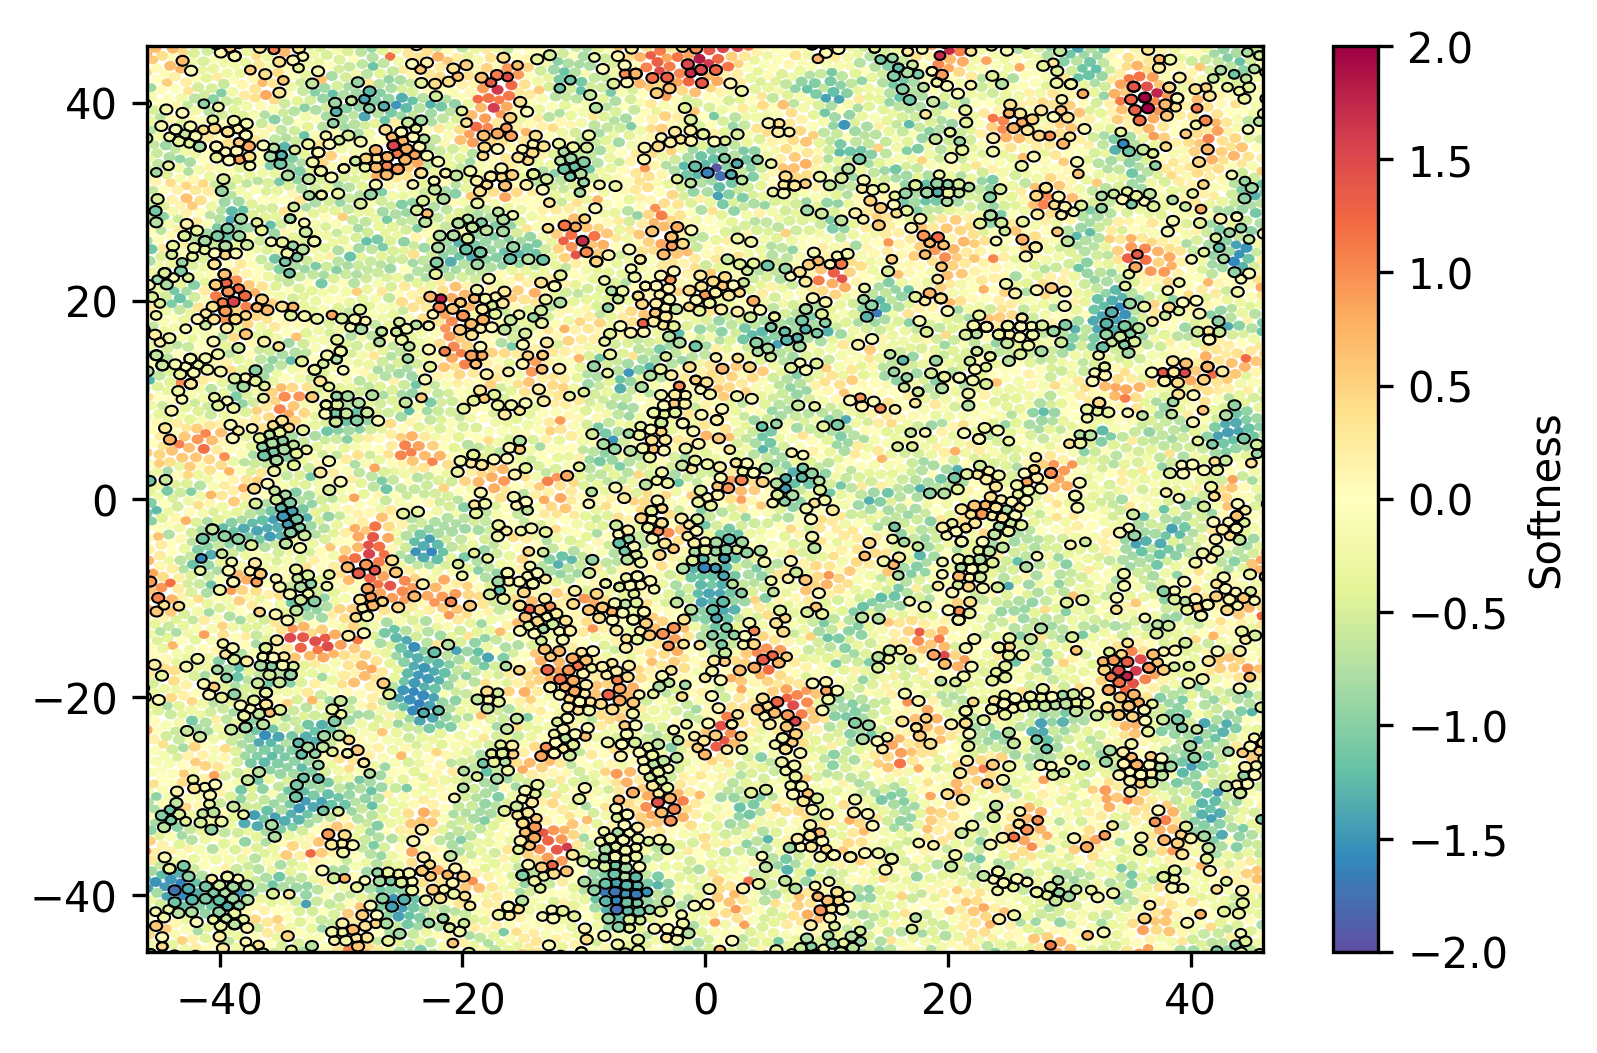

In [12]:
# mark t1 events

from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

snap = snap_0

# extract particle positions and data
positions = snap.particles.position
diams = snap.particles.diameter
color_data = soft_dataset[idx - 1]["soft"].to_numpy()[0]

# create a list of circles with positions and radius
circles = [Circle((x[0], x[1]), radius=d/2.0) for x, d in zip(positions, diams)]

# create a patch collection with circles and color data
# norm = colors.LogNorm(vmax=100)
norm = colors.Normalize(-2, 2)
import seaborn as sns
cmap = sns.color_palette("Spectral_r", as_cmap=True)
collection = PatchCollection(circles, cmap=cmap, norm=norm)
collection.set_array(color_data)
# norm2 = colors.Normalize(vmin=np.quantile(abs_data, 0.2), vmax=np.quantile(abs_data, 0.8))
# alpha = norm2(abs_data)
# # clamp between 0 and 1
# alpha = np.clip(alpha, 0, 1)
# collection.set_alpha(alpha)

# plot particles with color
fig, ax = plt.subplots(dpi=150)
ax.add_collection(collection)

rev_patches = []
for r in rev:
    rev_patches.append(Circle((positions[r[0]][0], positions[r[0]][1]), radius=diams[r[0]]/2.0))
    rev_patches.append(Circle((positions[r[1]][0], positions[r[1]][1]), radius=diams[r[1]]/2.0))

rev_col = PatchCollection(rev_patches, facecolor="none", edgecolor="black", linewidth=0.5)
ax.add_collection(rev_col)

ax.autoscale()

# zoom in 5x
zoom = 2
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim((xlim[0] + xlim[1])/2 - (xlim[1] - xlim[0])/zoom/2, (xlim[0] + xlim[1])/2 + (xlim[1] - xlim[0])/zoom/2)
ax.set_ylim((ylim[0] + ylim[1])/2 - (ylim[1] - ylim[0])/zoom/2, (ylim[0] + ylim[1])/2 + (ylim[1] - ylim[0])/zoom/2)

plt.colorbar(collection, label="Softness")

plt.show()


In [13]:
cmap.revers

AttributeError: 'LinearSegmentedColormap' object has no attribute 'reverse'

In [44]:
def plot_t1_rescaled_self(shear, axs=None, legend=True):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
    else:
        fig = axs[0].figure
    cmap = cm.inferno
    norm = colors.Normalize(vmin=0, vmax=.3)

    for k, v in output.items():
        if k.max_shear != shear:
            continue
        # print(k)
        c = cmap(norm(k.temp))
        if k.prep == "ESL":
            ls = "--"
        else:
            ls = "-"

        rev_count = np.mean([v_i["rev"] for v_i in v], axis=0)
        irr_count = np.mean([v_i["irr"] for v_i in v], axis=0)
        axs[0].plot(np.array(rev_count)/np.mean(rev_count[-5:]), color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}")
        axs[1].plot(np.array(irr_count)/np.mean(irr_count[-5:]), color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}")

    axs[0].set_ylabel("Reversible T1s / mean of last 5 cycles")
    axs[0].set_xlabel("Cycle")
    if legend:
        axs[0].legend(title="Temp Prep")
    axs[1].set_ylabel("Irreversible T1s / mean of last 5 cycles")
    axs[1].set_xlabel("Cycle")
    if legend:
        axs[1].legend(title="Temp Prep")
    fig.suptitle(f"T1s per cycle; {shear} shear, 1000 period; rescaled")

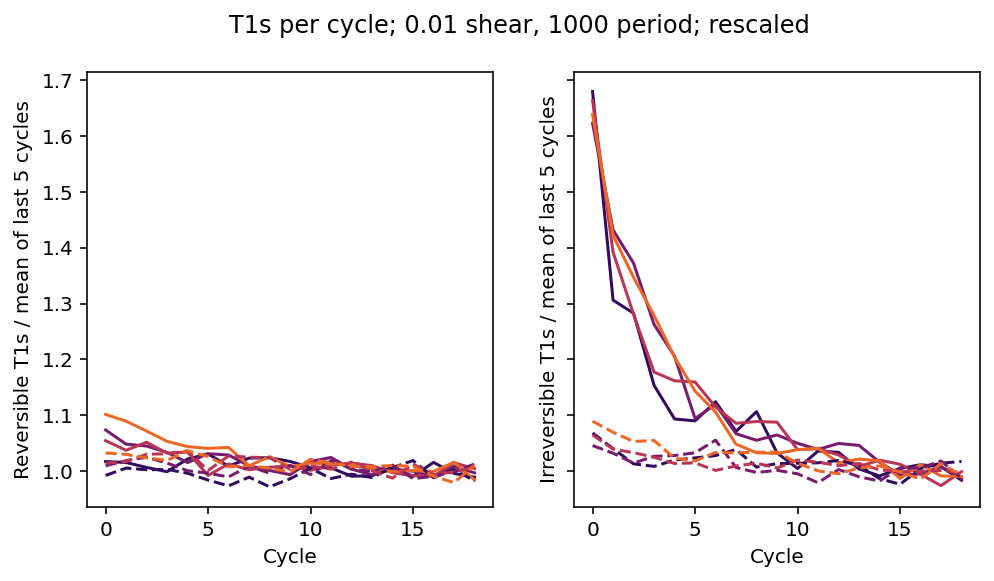

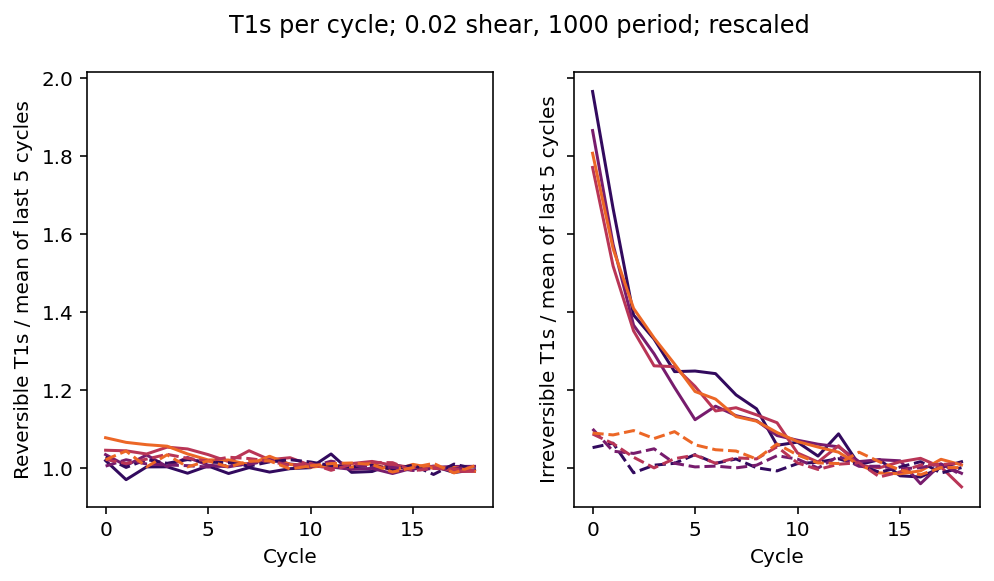

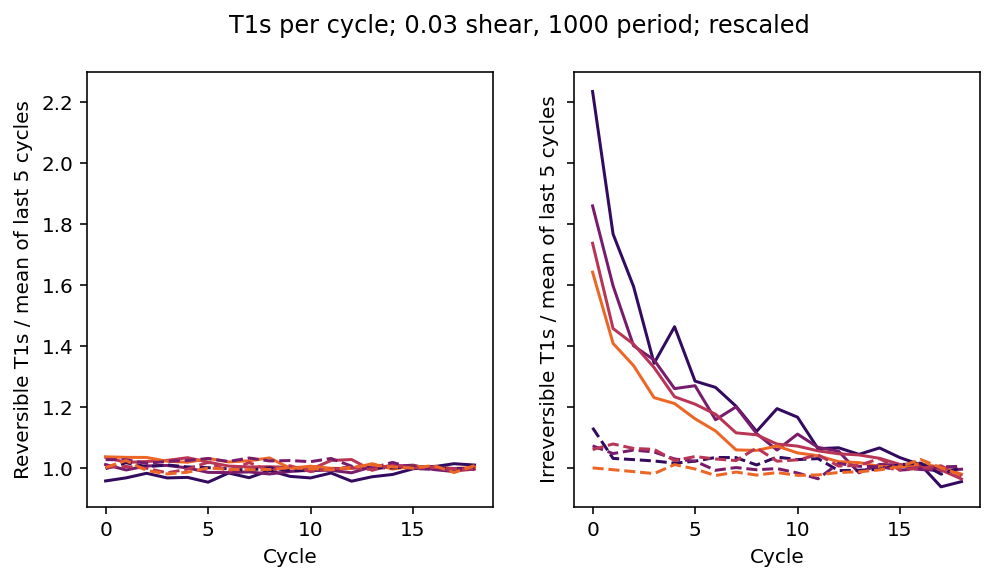

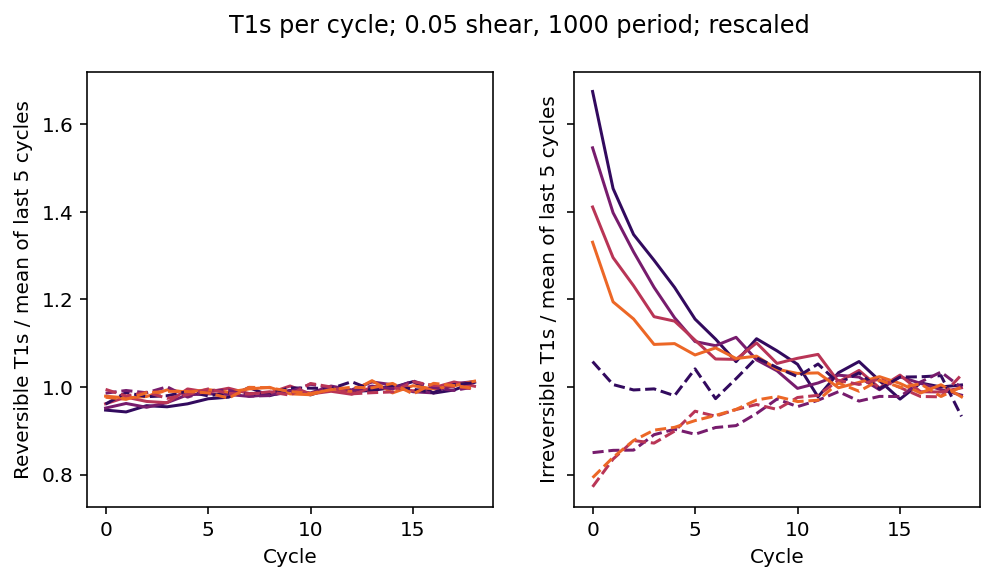

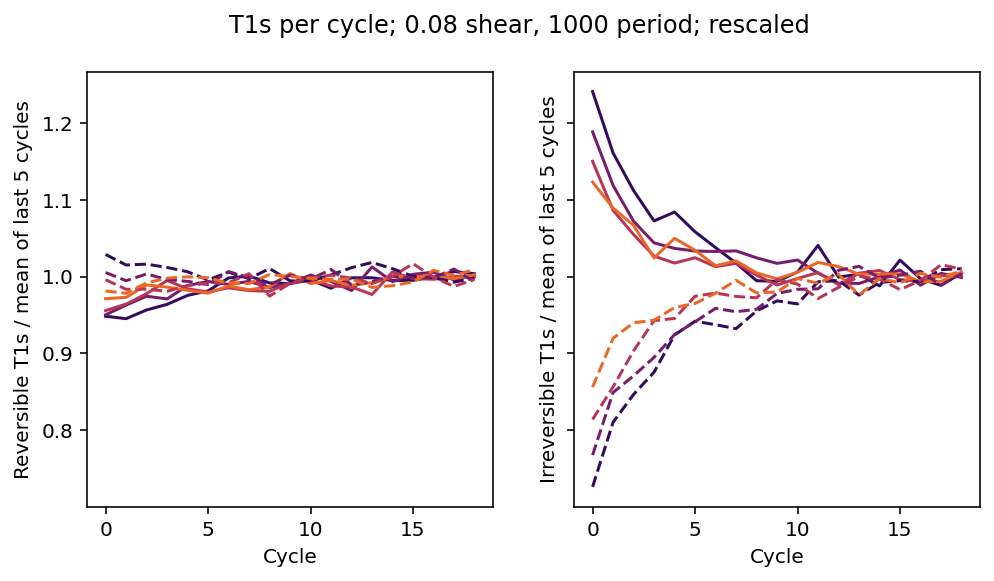

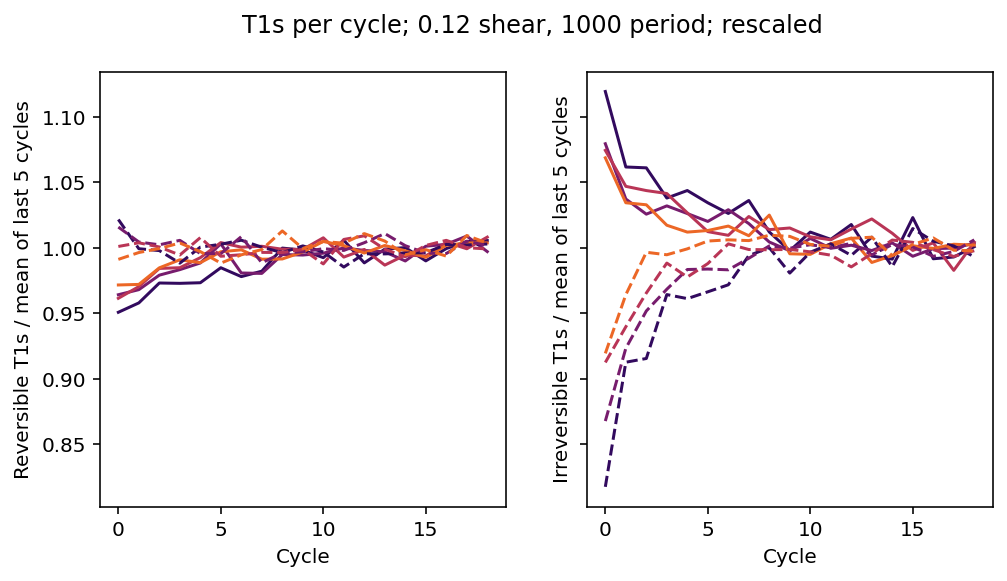

In [45]:
for shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plot_t1_rescaled_self(shear, legend=False)

Statepoint(max_shear=0.01, period=1000.0, temp=0.0496, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.0992, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.1488, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.1984, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.0496, prep='ESL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.0992, prep='ESL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.1488, prep='ESL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.1984, prep='ESL')


Text(0.5, 0.98, 'T1s per cycle; 0.01 shear, 1000 period')

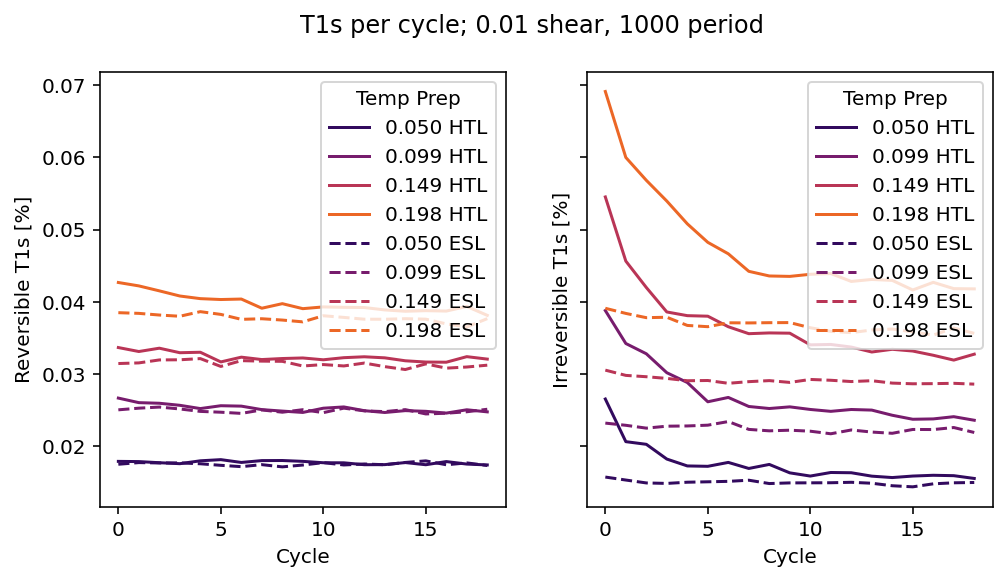

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
cmap = cm.inferno
norm = colors.Normalize(vmin=0, vmax=.3)

shear = 0.01

for k, v in output.items():
    print(k)
    c = cmap(norm(k.temp))
    if k.prep == "ESL":
        ls = "--"
    else:
        ls = "-"

    rev_count = np.mean([v_i["rev"] for v_i in v], axis=0)
    irr_count = np.mean([v_i["irr"] for v_i in v], axis=0)
    axs[0].plot(np.array(rev_count)/edges, color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}")
    axs[1].plot(np.array(irr_count)/edges, color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}")

axs[0].set_ylabel("Reversible T1s [%]")
axs[0].set_xlabel("Cycle")
axs[0].legend(title="Temp Prep")
axs[1].set_ylabel("Irreversible T1s [%]")
axs[1].set_xlabel("Cycle")
axs[1].legend(title="Temp Prep")
fig.suptitle(f"T1s per cycle; {shear} shear, 1000 period")

In [34]:
def plot_t1(shear, axs=None, legend=True):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
    else:
        fig = axs[0].figure
    cmap = cm.inferno
    norm = colors.Normalize(vmin=0, vmax=.3)

    for k, v in output.items():
        if k.max_shear != shear:
            continue
        # print(k)
        c = cmap(norm(k.temp))
        if k.prep == "ESL":
            ls = "--"
        else:
            ls = "-"

        rev_count = np.mean([v_i["rev"] for v_i in v], axis=0)
        irr_count = np.mean([v_i["irr"] for v_i in v], axis=0)
        axs[0].plot(np.array(rev_count)/edges, color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}")
        axs[1].plot(np.array(irr_count)/edges, color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}")

    axs[0].set_ylabel("Reversible T1s [%]")
    axs[0].set_xlabel("Cycle")
    if legend:
        axs[0].legend(title="Temp Prep")
    axs[1].set_ylabel("Irreversible T1s [%]")
    axs[1].set_xlabel("Cycle")
    if legend:
        axs[1].legend(title="Temp Prep")
    fig.suptitle(f"T1s per cycle; {shear} shear, 1000 period")

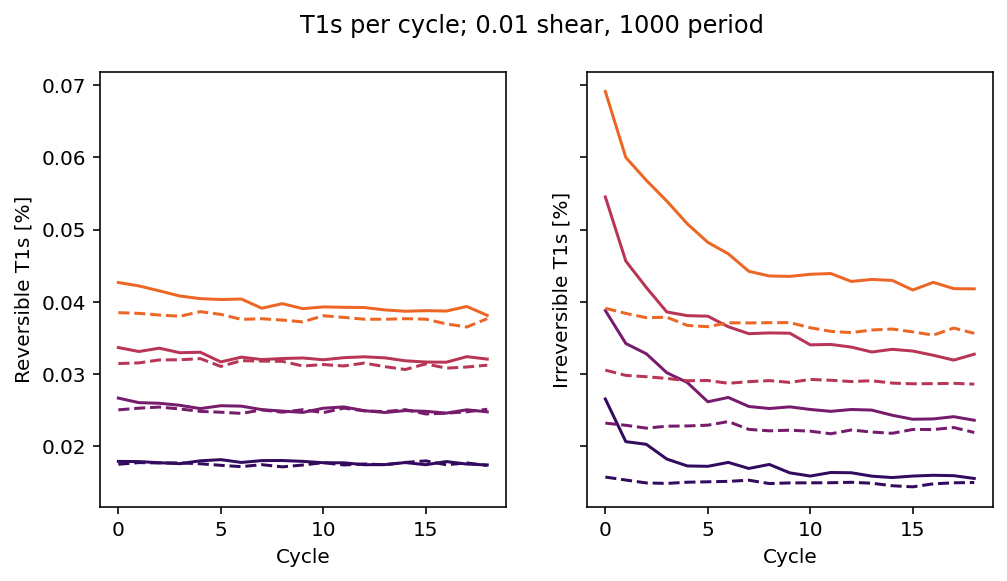

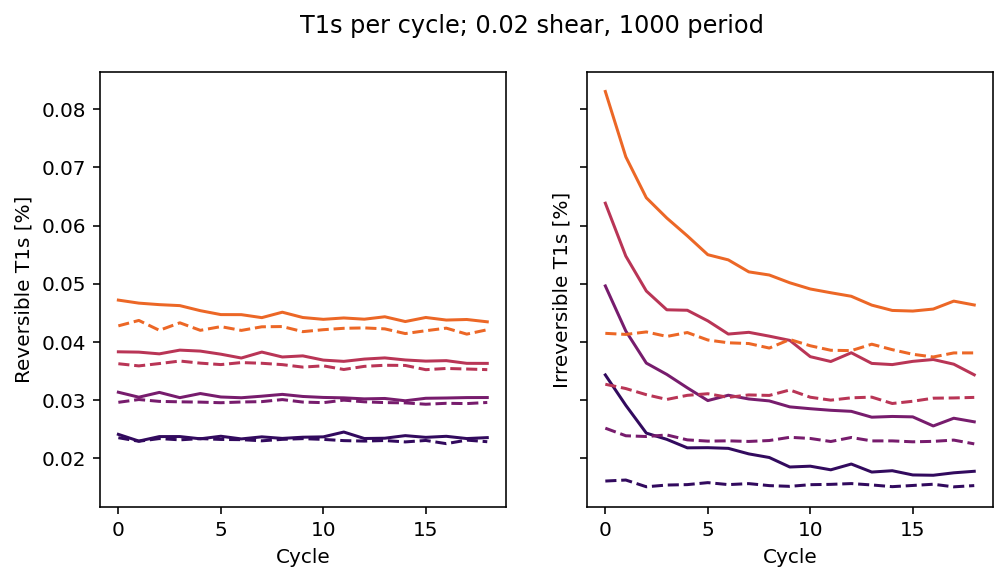

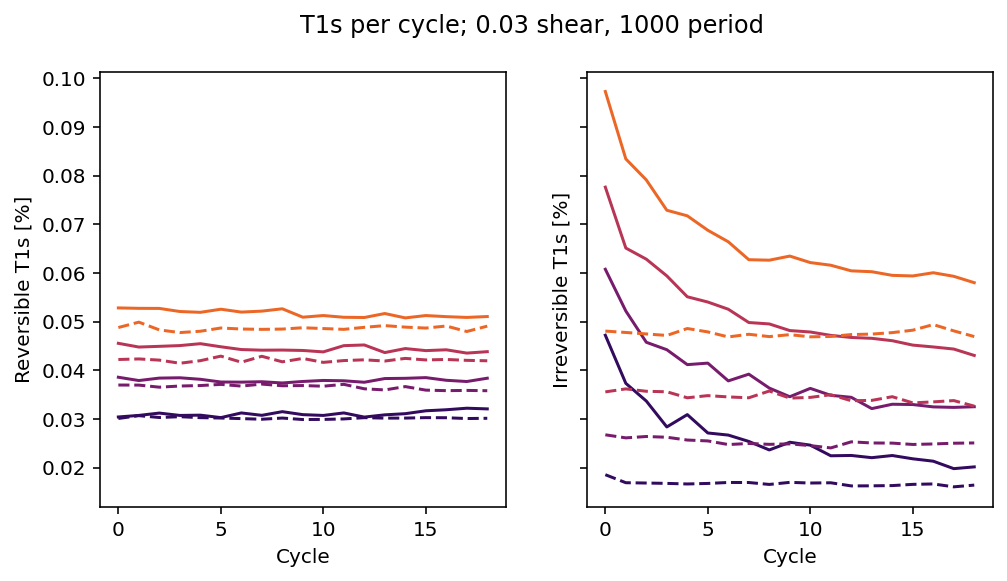

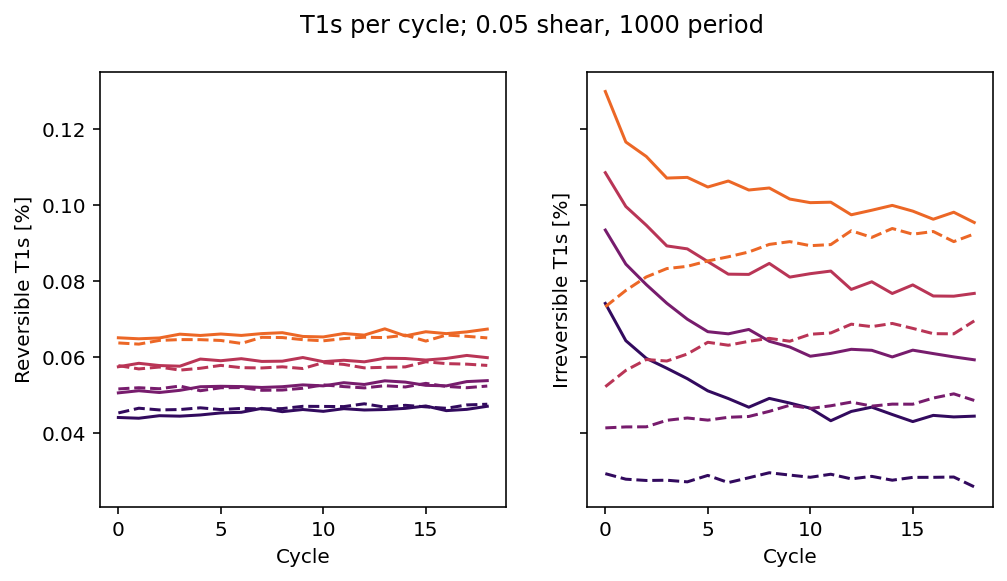

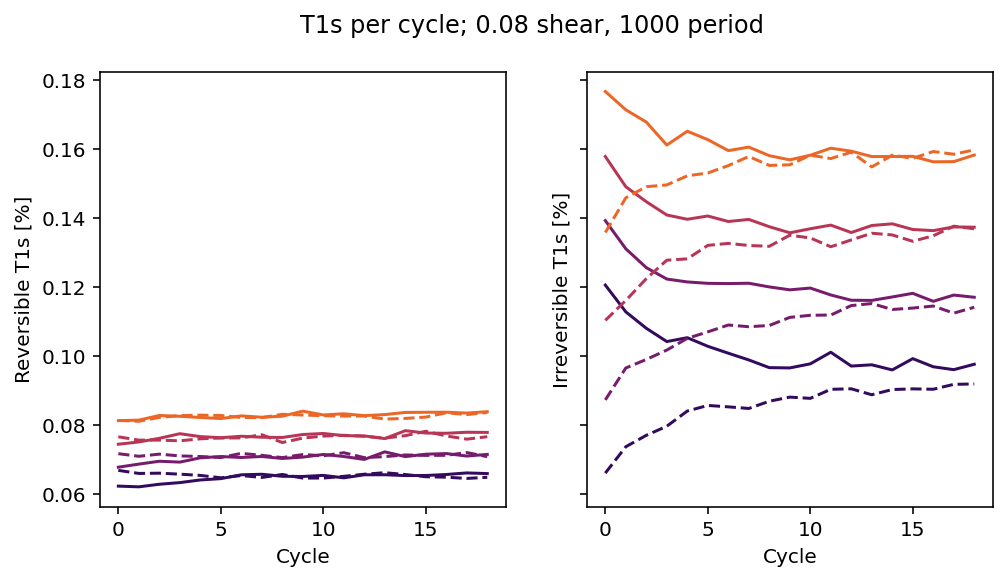

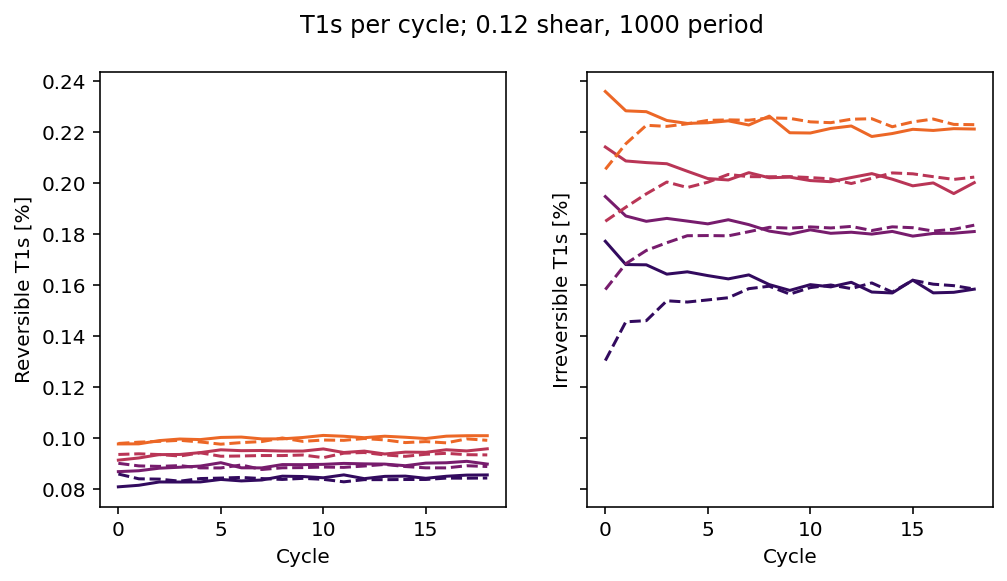

In [35]:
for shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plot_t1(shear, legend=False)

In [46]:
def plot_t1_rescaled_esl(shear, axs=None, legend=True):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
    else:
        fig = axs[0].figure
    cmap = cm.inferno
    norm = colors.Normalize(vmin=0, vmax=.3)

    for k, v in output.items():
        # print(k)
        if k.max_shear != shear:
                continue
        c = cmap(norm(k.temp))
        if k.prep == "ESL":
            ls = "--"
        else:
            ls = "-"

        esl_v = output[Statepoint(max_shear=k.max_shear, period=1000, temp=k.temp, prep="ESL")]

        rev_count = np.mean([v_i["rev"] for v_i in v], axis=0)
        irr_count = np.mean([v_i["irr"] for v_i in v], axis=0)
        esl_rev_count = np.mean([v_i["rev"] for v_i in esl_v], axis=0)
        esl_irr_count = np.mean([v_i["irr"] for v_i in esl_v], axis=0)
        axs[0].plot(np.array(rev_count)/np.mean(esl_rev_count[-5:]), color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}")
        axs[1].plot(np.array(irr_count)/np.mean(esl_irr_count[-5:]), color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}")

    axs[0].set_ylabel("Reversible T1s / mean of last 5 cycles ESL")
    axs[0].set_xlabel("Cycle")
    if legend:
        axs[0].legend(title="Temp Prep")
    axs[1].set_ylabel("Irreversible T1s / mean of last 5 cycles ESL")
    axs[1].set_xlabel("Cycle")
    if legend:
        axs[1].legend(title="Temp Prep")
    fig.suptitle(f"T1s per cycle; {shear} shear, 1000 period; rescaled")

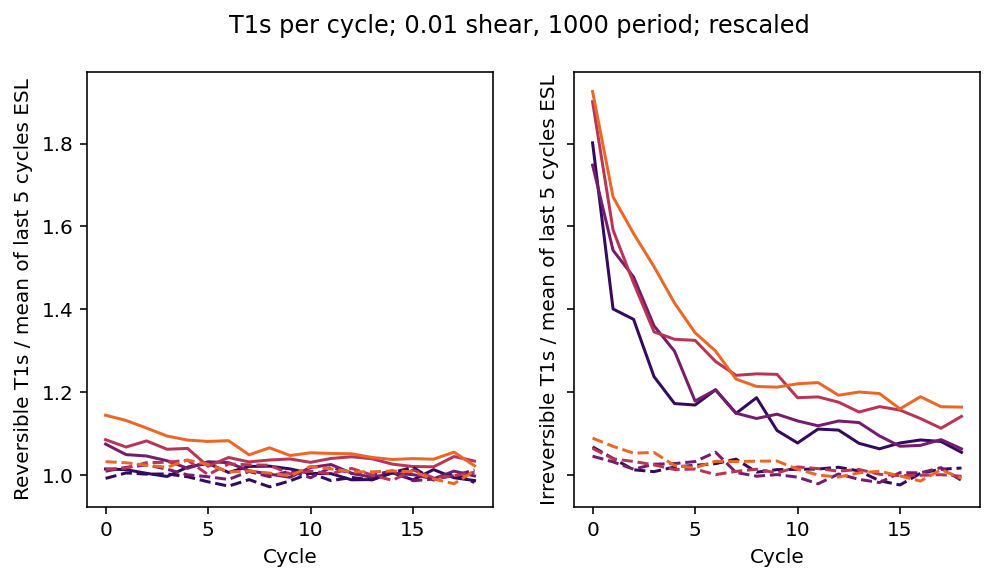

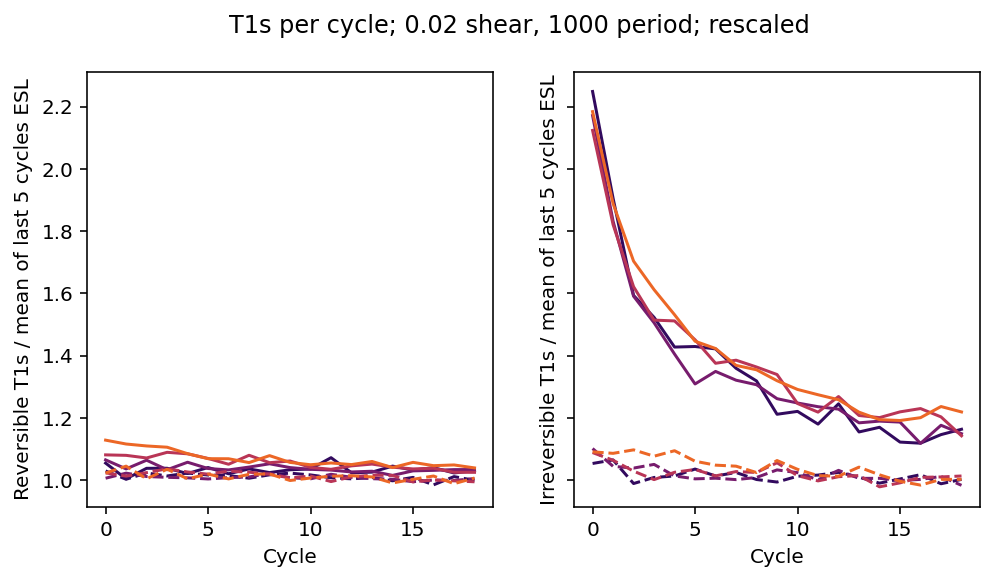

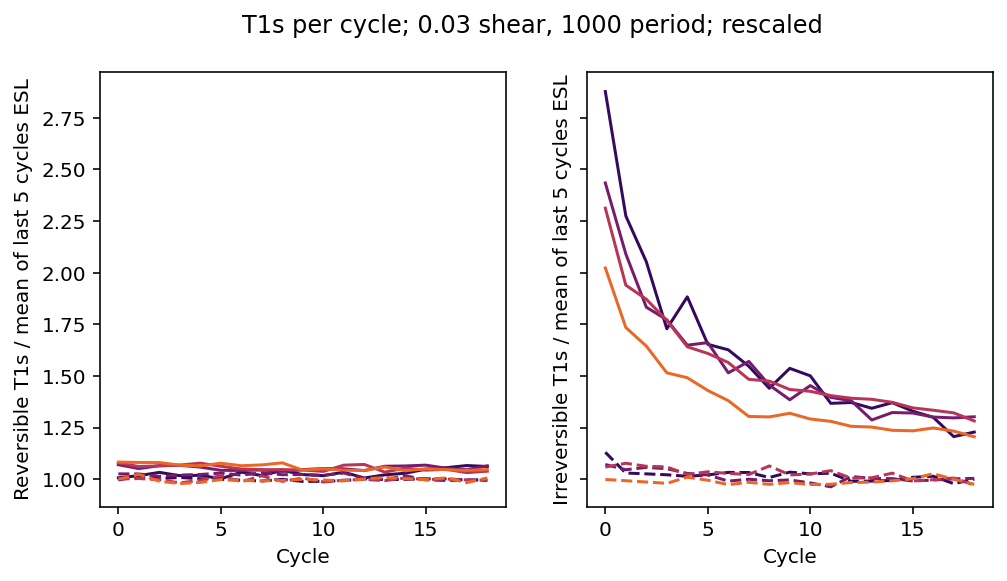

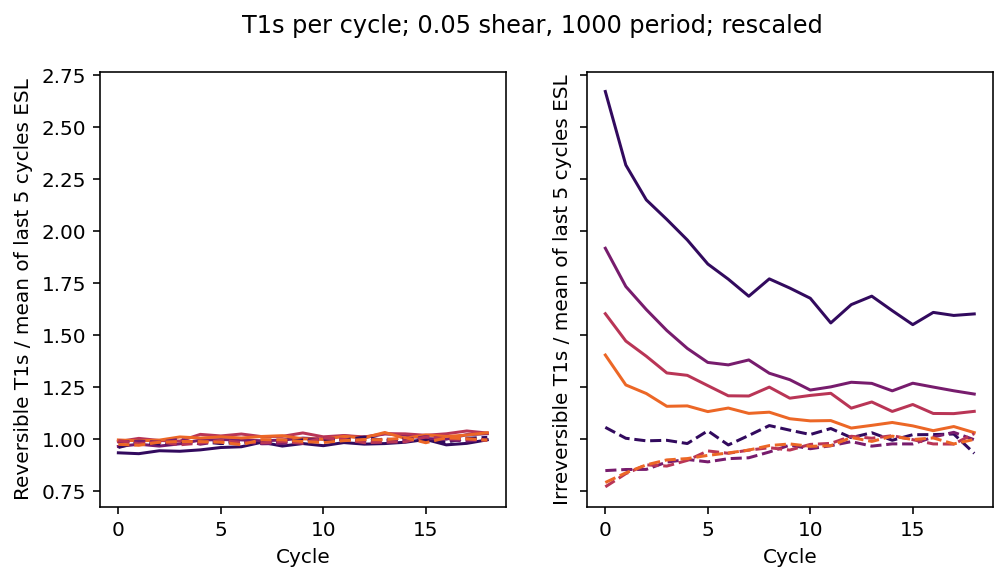

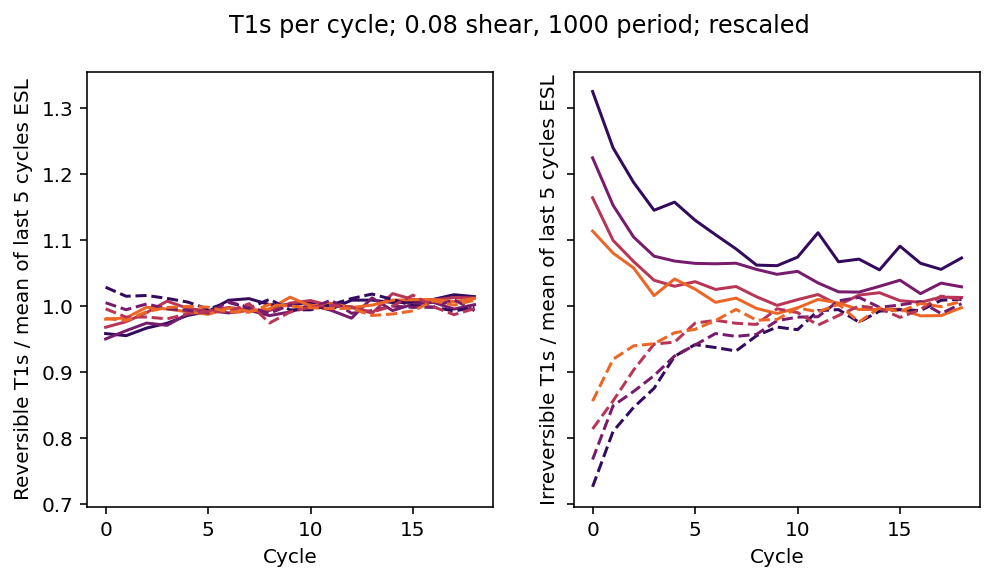

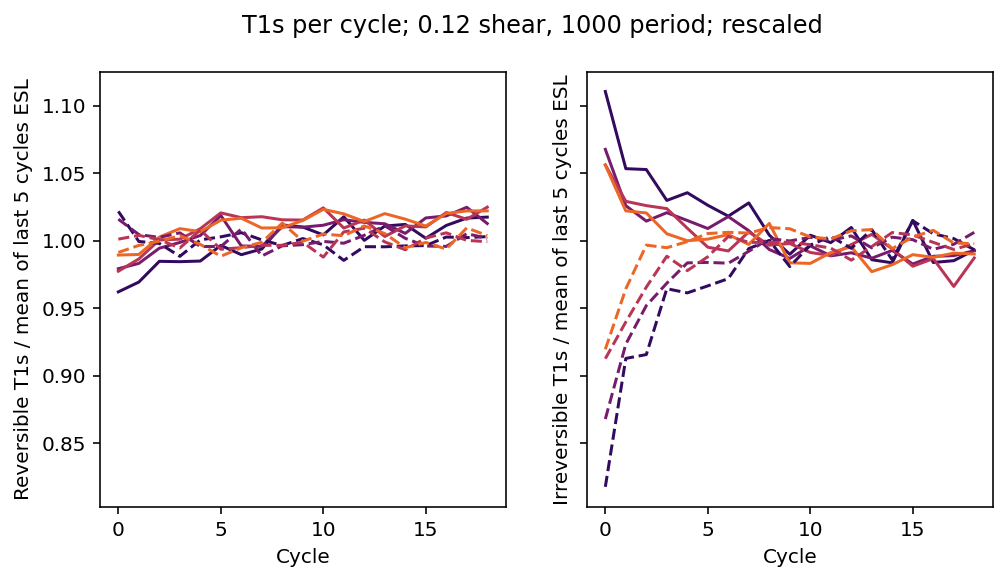

In [47]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)

for shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plot_t1_rescaled_esl(shear, legend=False)